### Ultimate Data Science Challenge

#### Exploratory data analysis

We are given a file containing timestamps of user logins in a particular location and we need to find interesting patterns in the resulting time series that characterize the underlying demand.

In [27]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [6]:
# Load json as string
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [10]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


There are 93412 recorded logins, some of them are duplicates as unique logins are only 92265. We will just aggregate these up for every user. 

We first look at 15 minute intervals aggregated across the full time interval between 1st of Jan and 13th of April

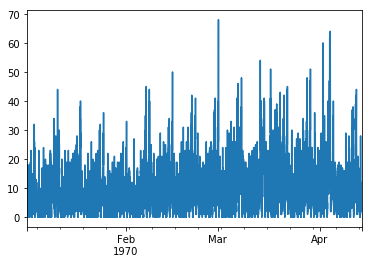

In [66]:
logins_agg_all = logins_no_dups.resample('15T').count()
logins_agg_all.plot()

We see that most of the logins are between 0-20, with some days showing a high volume of activity.

In [67]:
type(logins_agg_all)

pandas.core.series.Series

Lets plot a histogram and box plot to see what the distribution across all days.

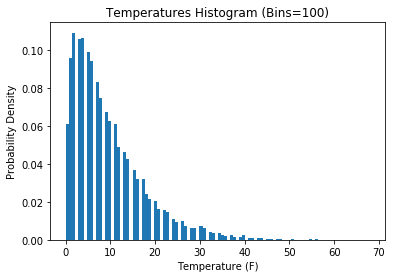

In [63]:
# Histogram
num_bins = 100
_ = plt.hist(logins_agg_all, density=True, bins=num_bins)
_ = plt.xlabel('Temperature (F)')
_ = plt.ylabel('Probability Density')
_ = plt.title('Temperatures Histogram (Bins=100)')

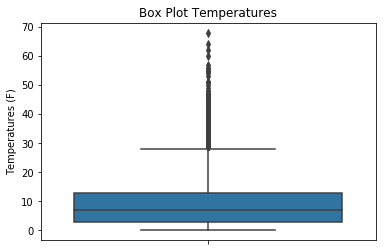

In [56]:
# Box Plot
_ = sns.boxplot(logins_agg_all, orient='v')
_ = plt.ylabel('Temperatures (F)')
_ = plt.xlabel('')
_ = plt.title('Box Plot Temperatures')

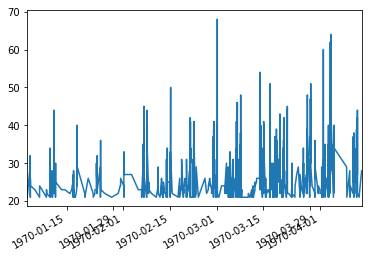

In [65]:
logins_agg_all.plot()

In [70]:
logins_agg_all.sort_values(ascending=False)

1970-03-01 04:30:00    68
1970-04-04 05:30:00    64
1970-04-04 01:30:00    62
1970-04-01 23:30:00    60
1970-04-04 01:15:00    57
1970-04-04 04:45:00    56
1970-04-04 01:45:00    56
1970-04-04 05:00:00    55
1970-04-04 05:15:00    55
1970-03-13 22:15:00    54
1970-04-04 01:00:00    53
1970-03-29 04:45:00    51
1970-03-17 01:30:00    51
1970-04-04 00:30:00    51
1970-02-15 04:45:00    50
1970-04-04 00:45:00    49
1970-03-08 04:45:00    48
1970-03-28 04:30:00    48
1970-03-01 04:45:00    47
1970-04-03 22:45:00    47
1970-04-03 23:15:00    47
1970-03-29 02:15:00    47
1970-03-07 03:00:00    46
1970-03-07 04:45:00    46
1970-04-04 03:15:00    46
1970-03-08 05:00:00    46
1970-02-07 04:30:00    45
1970-04-04 03:00:00    45
1970-03-22 04:30:00    45
1970-01-11 04:45:00    44
                       ..
1970-04-07 05:15:00     0
1970-01-27 05:30:00     0
1970-04-07 06:00:00     0
1970-04-07 06:30:00     0
1970-01-20 04:15:00     0
1970-04-07 06:45:00     0
1970-01-20 04:45:00     0
1970-04-07 0

AttributeError: 'DatetimeIndex' object has no attribute 'dt'